# Test the properties of the sampled CRF algorithm in the real model

Conclusion:
* After convergence, only top states have longest norm, thus largest potential
* The variance of potential is quite large
* Log sum exp becomes almost max function, only depend on largest input alpha, which consequently depend on strongest state 
    * When input gap larger than 10, log sum exp would become max
* Proposal according to L2 norm of state is the most correct way
* Next: try making variance of potential not that larger than 10, to that log sum exp would (hopefully) not become max

In [1]:
import torch 
import sklearn

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from torch import nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas import DataFrame

from collections import Counter
from tqdm import tqdm 
from data_utils import MSCOCOData
from transformers import GPT2Tokenizer, GPT2Model
from nltk.corpus import stopwords
from matplotlib.pyplot import figure
from matplotlib import collections as mc
from matplotlib.colors import ListedColormap

from frtorch.structure.linear_chain_crf import LinearChainCRF

In [2]:
# from https://github.com/mwaskom/seaborn/issues/2280

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

In [3]:
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
crf = LinearChainCRF('minmax', 10)

In [5]:
dataset = MSCOCOData(batch_size=10, 
                     test_batch_size=10)

Processing mscoco data ... 


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Reading mscoco raw data .. 
  data path: ../data/mscoco/captions_train2014.json


  0%|          | 0/414113 [00:00<?, ?it/s]

414113 sentences in total, 0.68sec


100%|██████████| 414113/414113 [00:00<00:00, 974143.19it/s] 


Reading mscoco raw data .. 
  data path: ../data/mscoco/captions_val2014.json


 35%|███▍      | 70455/202654 [00:00<00:00, 704481.81it/s]

202654 sentences in total, 0.40sec


  0%|          | 55/66068 [00:00<02:21, 467.60it/s]

Loading train and dev index
Processing sentence


100%|██████████| 66068/66068 [01:06<00:00, 996.14it/s] 


Padding to max sentence length 18
Padding to max bow length 9


100%|██████████| 40373/40373 [00:07<00:00, 5102.30it/s]


In [6]:
ckpt_path = '../models/gpt2net_test/state_matrix_e0_b400.pt'
ckpt = torch.load(ckpt_path)

state_matrix_l = ckpt['state_matrix_norm'] 
transition_l = ckpt['transition']
emission_l = ckpt['emission'] 
x_lens_l = ckpt['x_lens']
x_enc = ckpt['x_enc']
x_emb = ckpt['x_emb']

with torch.no_grad():
    ent = crf.entropy(transition_l, emission_l, x_lens_l)
    
print(ent)

tensor([34.6691], device='cuda:0')


In [7]:
ckpt_path = '../models/gpt2net_test/state_matrix_e0_b380.pt'
ckpt = torch.load(ckpt_path)

state_matrix_m = ckpt['state_matrix_norm'] 
transition_m = ckpt['transition']
emission_m = ckpt['emission'] 
x_lens_m = ckpt['x_lens']

with torch.no_grad():
    ent = crf.entropy(transition_m, emission_m, x_lens_m)
    
print(ent)

tensor([18.0880], device='cuda:0')


In [8]:
ckpt_path = '../models/gpt2net_test/state_matrix_e0_b350.pt'
ckpt = torch.load(ckpt_path)

state_matrix_s = ckpt['state_matrix_norm'] 
transition_s = ckpt['transition']
emission_s = ckpt['emission'] 
x_lens_s = ckpt['x_lens']

with torch.no_grad():
    ent = crf.entropy(transition_s, emission_s, x_lens_s)
    
print(ent)

tensor([6.4690], device='cuda:0')


In [9]:
def compare_mem(state_matrix, transition, emission, x_lens, N):
    with torch.no_grad():
        _, log_z_exact = crf.forward_sum(transition, emission, x_lens)

        log_z_est_20 = []
        log_z_est_200 = []
        log_z_est_400 = []
        for _ in tqdm(range(N)):
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=18, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_20.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=198, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_200.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=398, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_400.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_20 + log_z_est_200 + log_z_est_400
             ), 
             'memory': np.array(
                                  ['1%'] * N
                                  + ['10%'] * N
                                  + ['20%'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact[0], color='#CC2F27')
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
    return 

In [57]:
def compare_topk(state_matrix, transition, emission, x_lens, N, yloc=0.1, offset=0.1):
    with torch.no_grad():
        _, log_z_exact = crf.forward_sum(transition, emission, x_lens)
        log_z_ksum_25 = crf.forward_approx(state_matrix, emission, x_lens, sum_size=500, transition_proposal='l1norm', topk_sum=True)
        log_z_ksum_50 = crf.forward_approx(state_matrix, emission, x_lens, sum_size=1000, transition_proposal='l1norm', topk_sum=True)

        log_z_est_20 = []
        log_z_est_200 = []
        log_z_est_400 = []
        for _ in tqdm(range(N)):
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=18, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_20.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=198, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_200.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=398, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_400.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_20 + log_z_est_200 + log_z_est_400
             ), 
             'memory': np.array(
                                  ['1%'] * N
                                  + ['10%'] * N
                                  + ['20%'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact[0], color='#CC2F27')
        
        plt.axvline(x=log_z_ksum_25, color='gray')
        plt.axvline(x=log_z_ksum_50, color='gray')
        plt.text(log_z_ksum_25+offset, yloc+0.2, 'TopK Sum\n25% Mem', size=9)
        plt.text(log_z_ksum_50+offset, yloc, 'TopK Sum\n50% Mem', size=9)
        
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
    return 

In [83]:
def compare_proposal(state_matrix, transition, emission, x_lens, N):
    with torch.no_grad():
        _, log_z_exact = crf.forward_sum(transition, emission, x_lens)

        log_z_est_20 = []
        log_z_est_200 = []
        log_z_est_400 = []
        for _ in tqdm(range(N)):
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=18, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_20.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=198, proposal='softmax', transition_proposal='prod', sample_size=2)
            log_z_est_200.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=398, proposal='uniform', transition_proposal='none', sample_size=2)
            log_z_est_400.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_20 + log_z_est_200 + log_z_est_400
             ), 
             'proposal': np.array(
                                  ['emit. + l1norm'] * N
                                  + ['emit. + transit.'] * N
                                  + ['uniform'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact[0], color='#CC2F27')
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
    return 

# Large Level Entropy

## Memory Budget Comparison

100%|██████████| 200/200 [00:04<00:00, 43.60it/s]


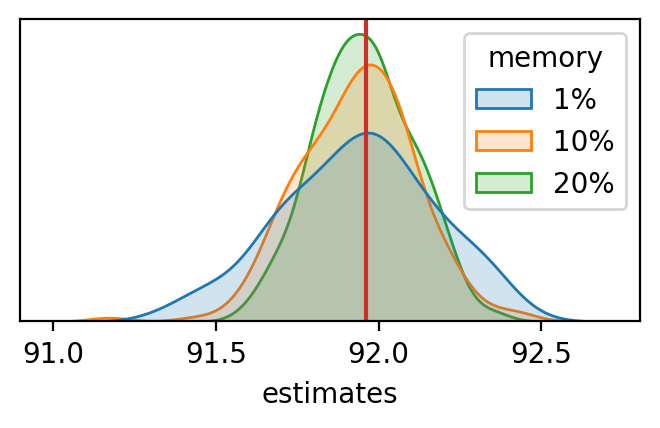

In [12]:
N=200
compare_mem(state_matrix_l, transition_l, emission_l, x_lens_l, N)

## TopK Comparison

100%|██████████| 200/200 [00:04<00:00, 44.08it/s]


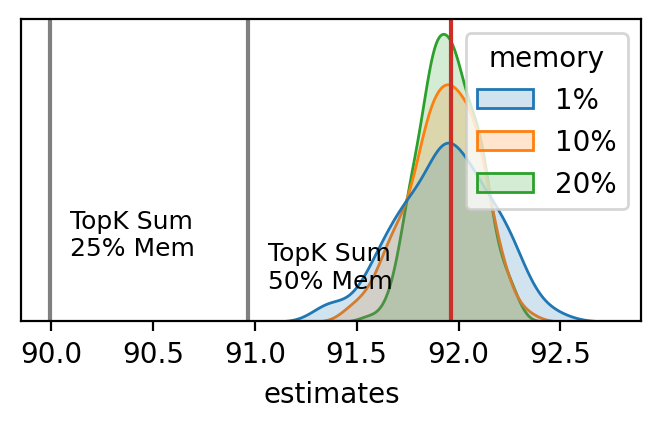

In [48]:
N=200
compare_topk(state_matrix_l, transition_l, emission_l, x_lens_l, N)

## Compare Proposal

100%|██████████| 200/200 [00:04<00:00, 43.42it/s]


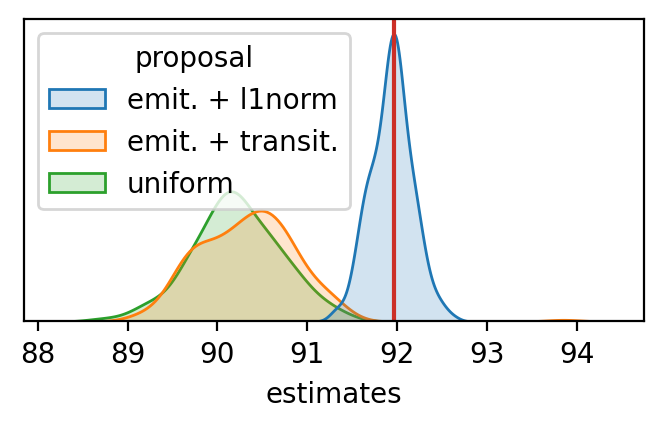

In [89]:
N=200
compare_proposal(state_matrix_l, transition_l, emission_l, x_lens_l, N)

----------

# Middle Level Entropy

## Memory Budget

100%|██████████| 200/200 [00:04<00:00, 44.80it/s]


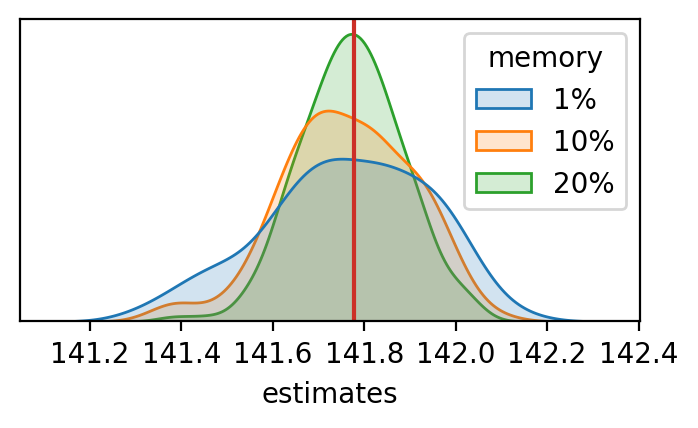

In [33]:
N=200
compare_mem(state_matrix_m, transition_m, emission_m, x_lens_m, N)

## TopK

100%|██████████| 200/200 [00:04<00:00, 44.88it/s]


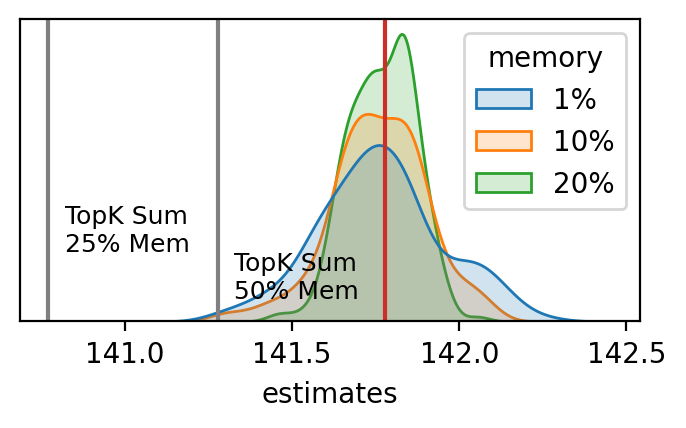

In [71]:
N=200
compare_topk(state_matrix_m, transition_m, emission_m, x_lens_m, N, yloc=0.1, offset=0.05)

## Proposal

100%|██████████| 200/200 [00:04<00:00, 43.43it/s]


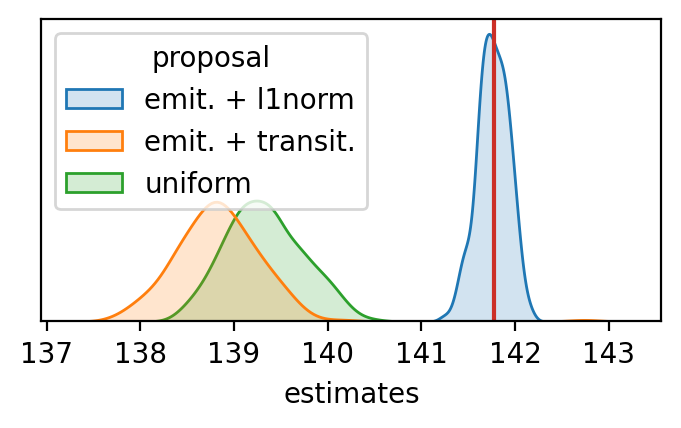

In [95]:
N=200
compare_proposal(state_matrix_m, transition_m, emission_m, x_lens_m, N)

--------

# Small Level Entropy

## Memory

100%|██████████| 500/500 [00:11<00:00, 44.85it/s]


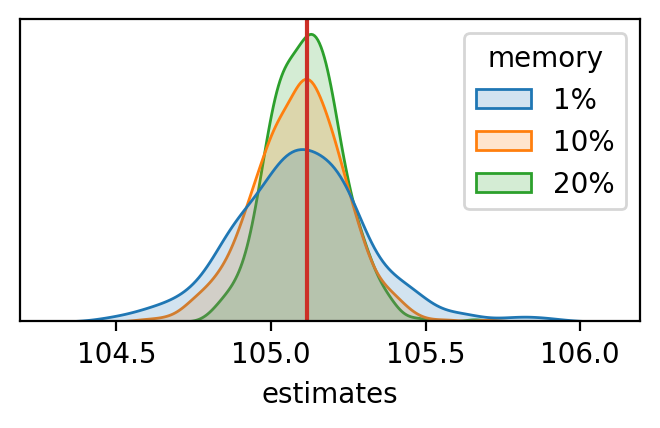

In [64]:
N=500
compare_mem(state_matrix_s, transition_s, emission_s, x_lens_s, N)

## topk

100%|██████████| 200/200 [00:04<00:00, 44.60it/s]


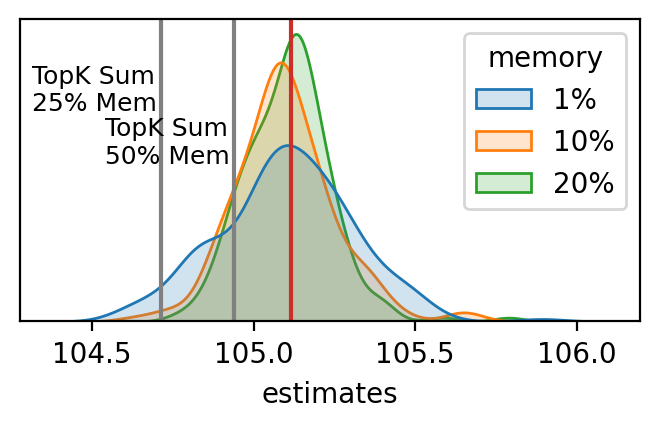

In [62]:
N=200
compare_topk(state_matrix_s, transition_s, emission_s, x_lens_s, N, yloc=0.6, offset=-0.4)

## Proposal

100%|██████████| 200/200 [00:04<00:00, 43.91it/s]


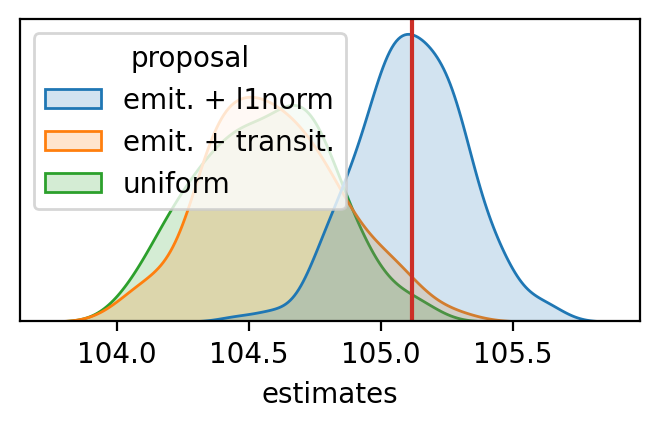

In [92]:
N=200
compare_proposal(state_matrix_s, transition_s, emission_s, x_lens_s, N)